### Build a regulatory network using scpy4reactome

This notebook is used to demonstrate the features provided by regulatory_network_constructor on how to develop a regulatory network based on scRNA-seq data.

**Note**: The original code was released at https://github.com/reactome-fi/sc_regulatory_network and merged here to consolidate the major scRNA-seq analysis and visualization features for Reactome at a single place.

#### Load the required packages

In [41]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '../scpy4reactome/')

import scanpy as sc
from tqdm import tqdm
import ktplotspy as kpy
import numpy as np

# The following works work with the whole github repo cloned. 
# Otherwise, install scpy4reactome as described in README.md.
from scpy4reactome import pathway_analyzer as pa
from scpy4reactome import regulatory_network_constructor as rnc
from scpy4reactome import nichenetpy as ntp
from scpy4reactome import cellphonedb_wrapper as cpw
# from nichenetpy import NicheNetWrapper as nw

import importlib
importlib.reload(pa)
importlib.reload(rnc)
importlib.reload(ntp)
importlib.reload(cpw)

# Use this since we cannot reload it.
# %run '../scpy4reactome/nichenetpy.py'
# %run '../scpy4reactome/regulatory_network_constructor.py'
# %run '../scpy4reactome/pathway_analyzer.py'

<module 'scpy4reactome.cellphonedb_wrapper' from '/Users/wug/git/reactome-fi/fi_sc_analysis/python/scpy4reactome/cellphonedb_wrapper.py'>

#### Load the data

Here we use a published mouse intestinal development epithethial single cell RNA-seq data generated at development E15.5. The original data will be released at GEO soon once the paper is published.

**Note**: The h5ad data has been pre-processed somewhere else.

In [42]:
# Parameters
working_dir = "/Volumes/ssd/bmi1/E15.5/"
h5ad_file = working_dir + "epithethial_mesenchymal_harmony_03282024.h5ad"

In [2]:
# Load the data
adata = sc.read_h5ad(h5ad_file)
adata

AnnData object with n_obs × n_vars = 16645 × 18276
    obs: 'scrublet_doublet_score', 'scrublet_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-E15.5_Epithelial', 'n_cells_by_counts-E15.5_Epithelial', 'mean_counts-E15.5_Epithelial', 'pct_dropout_by_counts-E15.5_Epithelial', 'total_counts-E15.5_Epithelial', 'highly_variable-E15.5_Epithelial', 'means-E15.5_Epithelial', 'dispersions-E15.5_Epithelial', 'dispersions_norm-E15.5_Epithelial', 'n_cells-E15.5_Mesenchymal', 'n_cells_by_counts-E15.5_Mesenchymal', 'mean_counts-E15.5_Mesenchymal', 'pct_dropout_by_counts-E15.5_Mesenchymal', 'total_counts-E15.5_Mesenchymal', 'highly_variable-E15.5_Mesenchymal', 'means-E15.5_Mesenchymal', 'dispersions-E15.5_Mesenchymal', 'dispersions_norm-E15.5_Mesenchymal', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

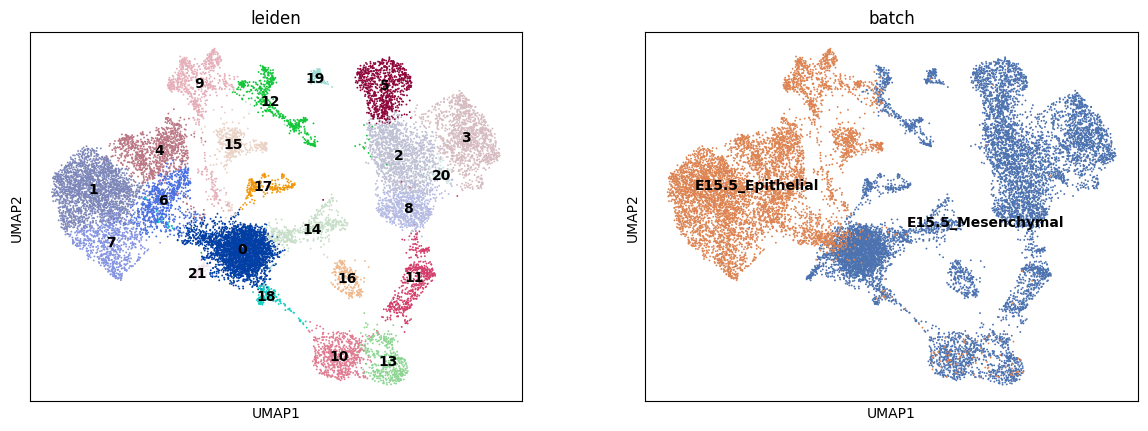

In [3]:
# Quick view about clusters and batches if any
sc.pl.umap(adata, color=['leiden', 'batch'], legend_loc='on data')

#### Calculate pathway and tf activities using AUCell

In [33]:
# Calculate pathway activilities
pa.reactome_aucell(adata, 
                   reactome_gmt='../resources/MouseReactomePathways_Rel_79_122921.gmt',
                   data_key=pa.AUCELL_KEY)

Less than 80% of the genes in Class A/1 (Rhodopsin-like receptors) are present in the expression matrix.
Less than 80% of the genes in Class B/2 (Secretin family receptors) are present in the expression matrix.
Less than 80% of the genes in Class C/3 (Metabotropic glutamate/pheromone receptors) are present in the expression matrix.
Less than 80% of the genes in ABC transporters in lipid homeostasis are present in the expression matrix.
Less than 80% of the genes in ABO blood group biosynthesis are present in the expression matrix.
Less than 80% of the genes in Abacavir transmembrane transport are present in the expression matrix.
Less than 80% of the genes in Acetylation are present in the expression matrix.
Less than 80% of the genes in Acetylcholine binding and downstream events are present in the expression matrix.
Less than 80% of the genes in Acrosome Reaction and Sperm:Oocyte Membrane Binding are present in the expression matrix.
Less than 80% of the genes in Activated NTRK2 sign

In [34]:
# Calculate TF activities
dorothea_tfs = pa.load_dorothea_data('../resources/dorothea_mm.tsv')
pa.reactome_aucell(adata=adata,
                   reactome_gmt=dorothea_tfs,
                   data_key=pa.TF_AUCELL_KEY)

Less than 80% of the genes in Ahr are present in the expression matrix.
Less than 80% of the genes in Esr1 are present in the expression matrix.
Less than 80% of the genes in Cdx2 are present in the expression matrix.
Less than 80% of the genes in Foxl2 are present in the expression matrix.
Less than 80% of the genes in Cebpb are present in the expression matrix.
Less than 80% of the genes in Creb1 are present in the expression matrix.
Less than 80% of the genes in Hnf1a are present in the expression matrix.
Less than 80% of the genes in Hnf4a are present in the expression matrix.
Less than 80% of the genes in Hnf4g are present in the expression matrix.
Less than 80% of the genes in Ets1 are present in the expression matrix.
Less than 80% of the genes in Ets2 are present in the expression matrix.
Less than 80% of the genes in Fli1 are present in the expression matrix.
Less than 80% of the genes in Fos are present in the expression matrix.
Less than 80% of the genes in Fosl1 are present

In [233]:
# Calculate ligand activities
nichenet = NicheNetWrapper('mouse')

In [30]:
ligand2targets = nichenet.get_ligand_2_targets(adata.var_names)
print(len(ligand2targets))
# for name, geneset in ligand2targets.items():
#     print('{}: {}'.format(name, len(geneset)))

1287


In [31]:
pa.reactome_aucell(adata=adata,
                reactome_gmt=ligand2targets,
                data_key=pa.LIGAND_AUCELL_KEY)

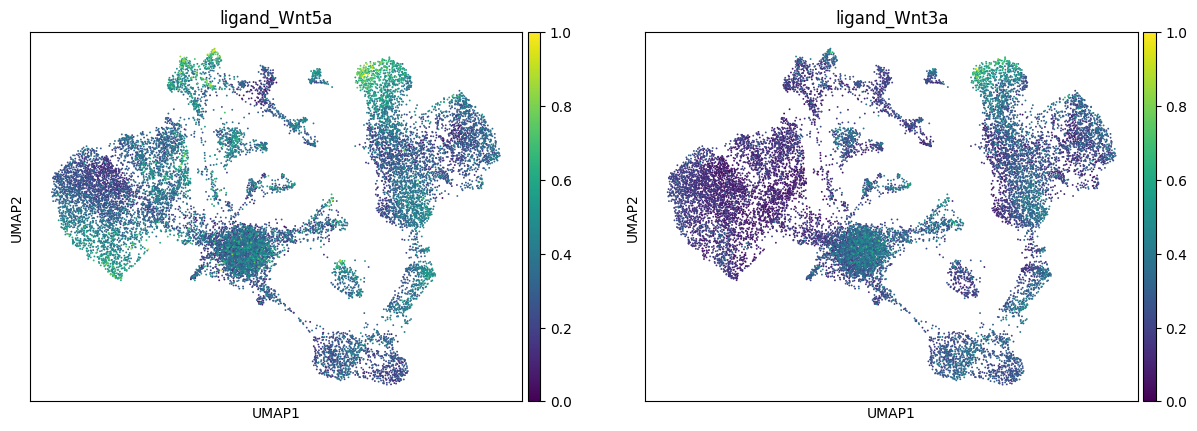

In [32]:
ligand_analyzer = pa.PathwayAnalyzer()
ligand_analyzer.adata = adata
ligand_analyzer.adata_key = pa.LIGAND_AUCELL_KEY

ligand_analyzer.color_pathway_umap(['Wnt5a', 'Wnt3a'], color_cluster=False, obs_name_prefix='ligand_')

#### Dump the adata for the time being with all aucell values

In [35]:
new_data_file = working_dir + 'epithethial_mesenchymal_harmony_03282024_with_aucells.h5ad'
adata.write_h5ad(new_data_file)

#### Load back the data with AUCell activities

In [3]:
new_data_file = working_dir + 'epithethial_mesenchymal_harmony_03282024_with_aucells.h5ad'
adata = sc.read_h5ad(new_data_file)

#### Select TFs, pathways, and ligands for a cluster

##### Subset Anndata

In [4]:
# Cluster 1 has been annotated as a stem cell cluster at E15.5
focused_cluster = '1' # Need to use string
# Compare the selected cluster to other clusters for epithethial cells only
adata_epi = adata[adata.obs['batch'] == 'E15.5_Epithelial']
# Let's use the one way annova to perform differential activity analysis
# Before we can do that, let's split all cells into two groups
adata_epi.obs['focused_cluster'] = adata_epi.obs['leiden'].map(lambda c : '1' if c == focused_cluster else '0')
adata_epi

AnnData object with n_obs × n_vars = 6513 × 18276
    obs: 'scrublet_doublet_score', 'scrublet_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'batch', 'ligand_Wnt5a', 'ligand_Wnt3a', 'focused_cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-E15.5_Epithelial', 'n_cells_by_counts-E15.5_Epithelial', 'mean_counts-E15.5_Epithelial', 'pct_dropout_by_counts-E15.5_Epithelial', 'total_counts-E15.5_Epithelial', 'highly_variable-E15.5_Epithelial', 'means-E15.5_Epithelial', 'dispersions-E15.5_Epithelial', 'dispersions_norm-E15.5_Epithelial', 'n_cells-E15.5_Mesenchymal', 'n_cells_by_counts-E15.5_Mesenchymal', 'mean_counts-E15.5_Mesenchymal', 'pct_dropout_by_counts-E15.5_Mesenchymal', 'total_counts-E15.5_Mesenchymal', 'highly_variable-E15.5_Mesenchymal', 'means-E15.5_Mesenchymal', 'dispersions-E15.5_Mesenchymal', 'dispersions_norm-E15.5_Mesenchymal', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_

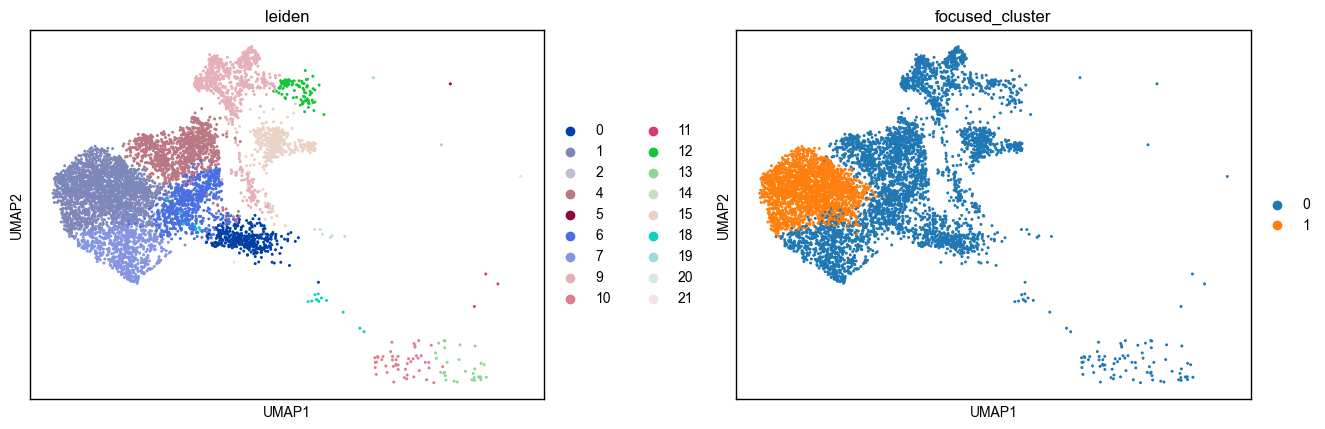

In [5]:
sc.pl.umap(adata_epi, color=['leiden', 'focused_cluster'], wspace=0.25)

##### Work on ligands first

##### Perform DA analysis for ligands

In [6]:
# Perform differential activity analysis for TFs
# %run '../scpy4reactome/pathway_analyzer.py'
pathway_analyzer = pa.PathwayAnalyzer()
pathway_analyzer.adata = adata_epi
pathway_analyzer.adata_key = pa.LIGAND_AUCELL_KEY
ligand_diff_df = pathway_analyzer.perform_diff_activity_analysis('1', '0', 'focused_cluster', True)

(<Axes: ylabel='stat'>, <Axes: ylabel='-log10(fdr)'>)

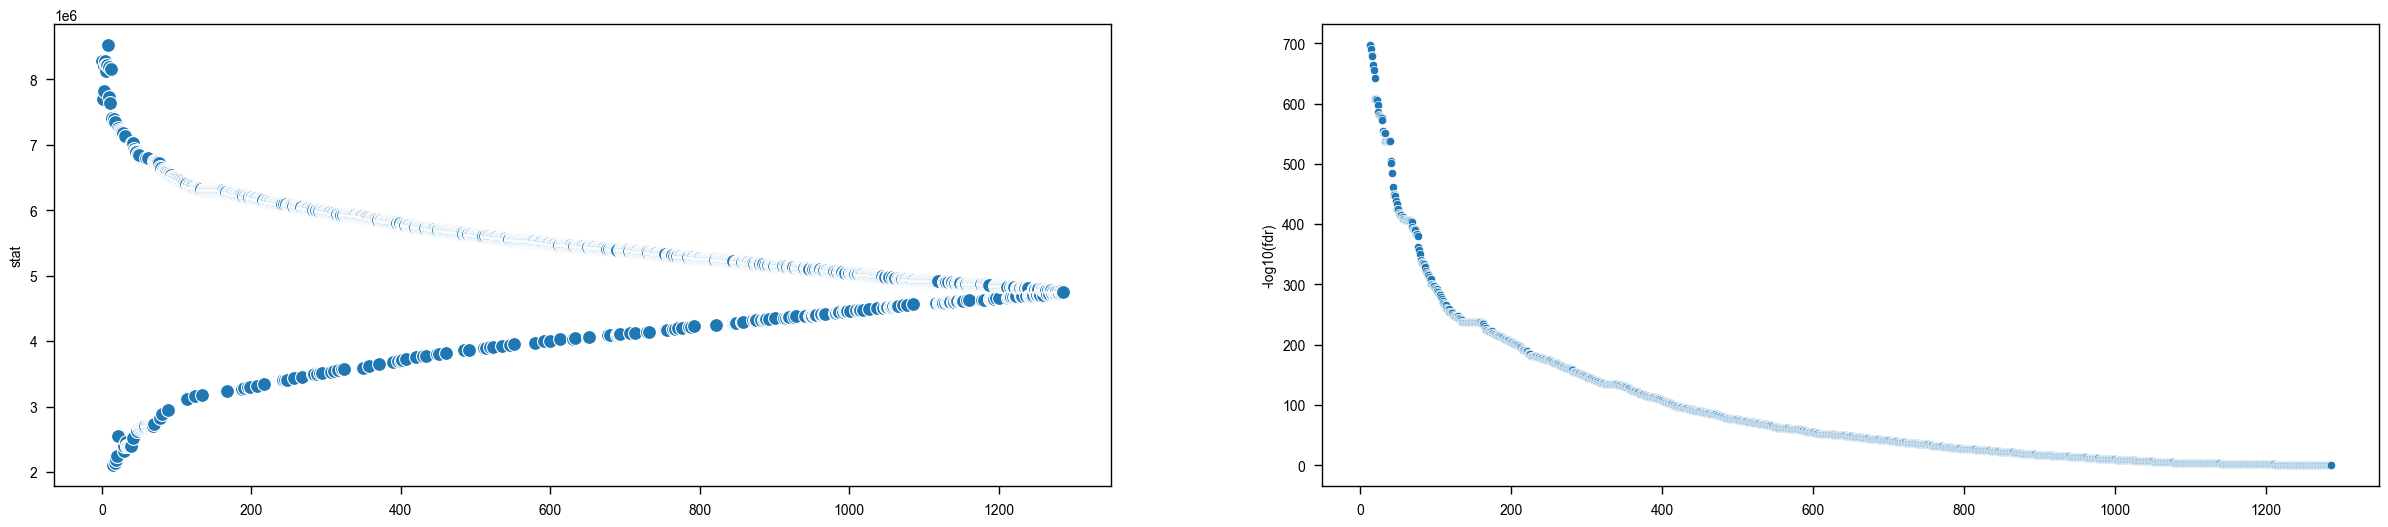

In [7]:
rnc.plot_diff_activity(ligand_diff_df, sort_by_fdr=True)

**Note**: The ligands using this approach may not be expressed. Therefore, we need more approaches to choose them, e.g. simple expression levels, cellphonedb.

##### Subset ligands to expressed genes (10% of cells as the default by NicheNet)

##### Initialize NicheNet first

In [8]:
# This step takes about 15 seconds!
nichenet = ntp.NicheNetWrapper('mouse')

Total expressed genes: 9209


(<Axes: ylabel='stat'>, <Axes: ylabel='-log10(fdr)'>)

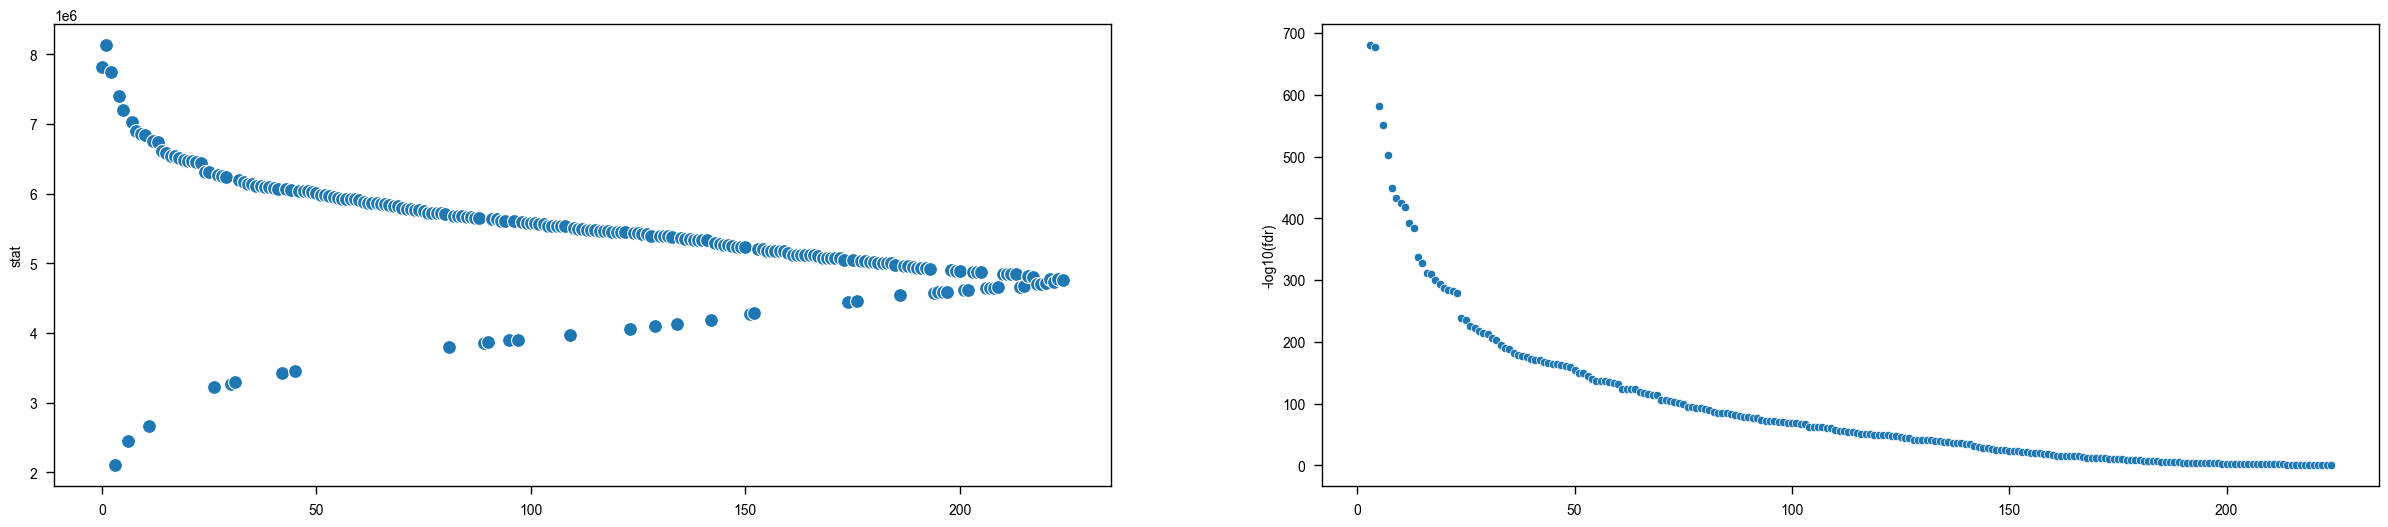

In [9]:
# First let's get all expressed genes in all cells
all_genes = nichenet.get_expressed_genes(adata_epi)
print('Total expressed genes: {}'.format(len(all_genes)))
# Do a filter to select the genes
ligand_diff_df = ligand_diff_df.loc[ligand_diff_df['feature'].isin(all_genes)]
rnc.plot_diff_activity(ligand_diff_df, sort_by_fdr=True)

In [10]:
ligand_diff_df

feature       stat        p-value  median_diff  mean_diff            fdr  \
0      Mmp15  7823409.0   0.000000e+00     0.132519   0.145161   0.000000e+00   
1        Pam  8127108.0   0.000000e+00     0.170957   0.183308   0.000000e+00   
2     Ptdss1  7739170.5   0.000000e+00     0.121582   0.131755   0.000000e+00   
3       Tgm2  2101020.0  5.300344e-298    -0.071737  -0.111429  4.263464e-296   
4      Mfge8  7395212.5  3.776969e-297     0.101928   0.101070  2.859387e-295   
..       ...        ...            ...          ...        ...            ...   
220     Patj  4712329.5   6.040382e-01     0.003937  -0.011087   6.169819e-01   
221     Liph  4770413.0   7.716238e-01     0.005801  -0.005570   7.794975e-01   
222     Gas6  4729195.0   7.766141e-01     0.002547  -0.006115   7.833090e-01   
223      Ang  4768818.0   7.886688e-01     0.003990  -0.006168   7.948447e-01   
224  Ceacam1  4759150.5   8.938687e-01     0.003388  -0.006372   8.952599e-01   

     -log10(fdr)  
0            inf  
1            inf  
2            inf  
3     680.115106  
4     678.211995  
..           ...  
220     0.482916  
221     0.249106  
222     0.244228  
223     0.229608  
224     0.110641  

[225 rows x 7 columns]

Total selected ligands from diff act analysis: 167


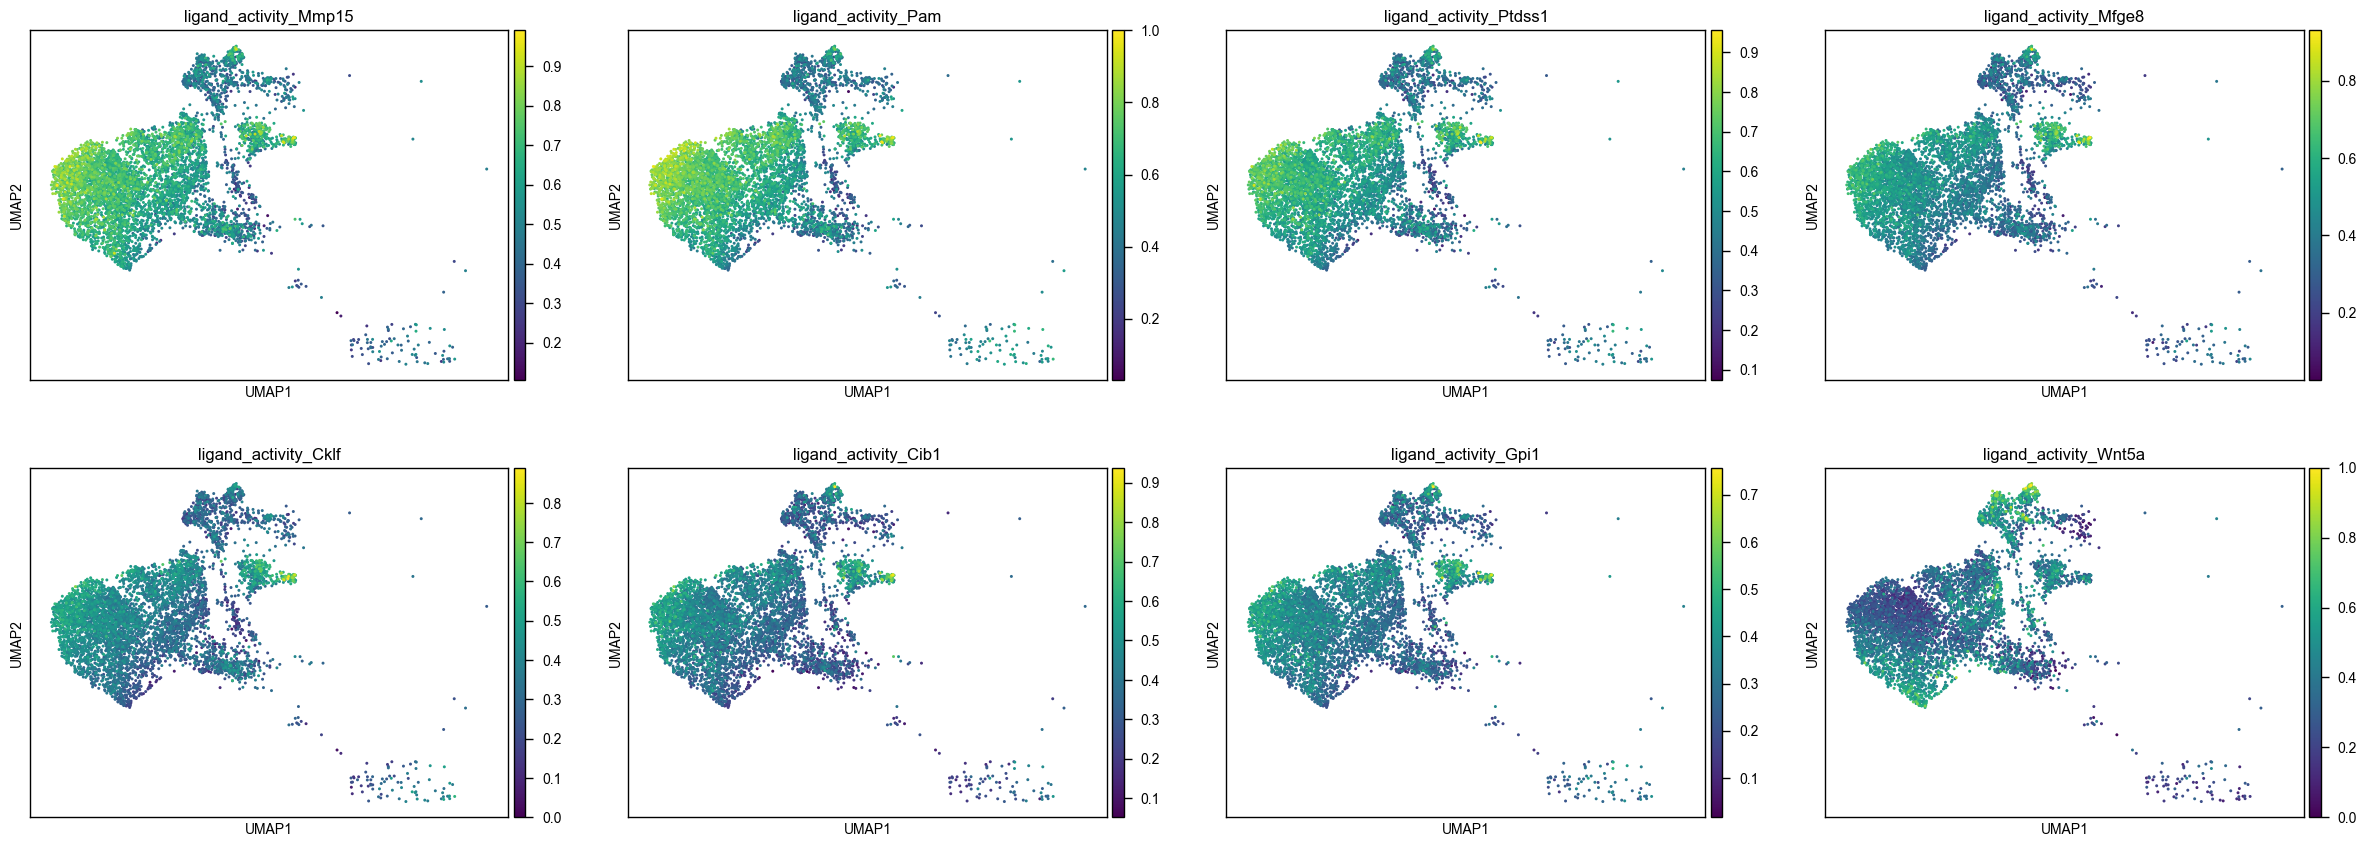

In [11]:
# Based on the above two plots, we should choose the top 50 for ligands activity analysis
# Since we are going to perform an overlap analysis from CellPhoneDB results, let's just use significant ligands
# We also like to focus on up-regulated ligands here
fdr_cutoff = 0.01
which_ligands = (ligand_diff_df['fdr'] < fdr_cutoff) & (ligand_diff_df['median_diff'] > 0)
selected_ligands_from_da = ligand_diff_df['feature'][which_ligands].to_list()
print('Total selected ligands from diff act analysis: {}'.format(len(selected_ligands_from_da)))
# Do a plot
plotted_ligands = selected_ligands_from_da[:7]
plotted_ligands.append('Wnt5a') # This is not selected. Just plot for comparison
# Note: Wnt5a activity actually is lower in the focused cluster (1) compared to other epi clusters!
# print(ligand_diff_df[ligand_diff_df['feature'] == 'Wnt5a'])
pathway_analyzer.color_pathway_umap(pathways=plotted_ligands, color_cluster=False, obs_name_prefix='ligand_activity_')

##### Use the original nichenet to check the top activity ligands

In [12]:
# Perform a DEX first
sc.tl.rank_genes_groups(adata_epi, groupby='focused_cluster', groups=['1'], reference='0')
focused_cluster_deg_df = sc.get.rank_genes_groups_df(adata_epi, group='1', pval_cutoff=0.01, log2fc_min=1)
focused_cluster_deg = focused_cluster_deg_df['names']
print('Total DEG selected: {}'.format(len(focused_cluster_deg)))
background_genes = nichenet.get_expressed_genes(adata_epi, '1', 'focused_cluster')
print('Total background genes: {}'.format(len(background_genes)))

Total DEG selected: 946
Total background genes: 9654


In [13]:
# Perform nichenet analysis
nichenet_ligand_activities_df = nichenet.predict_ligand_activities(geneset=focused_cluster_deg,
                                                                   background_expressed_genes=background_genes,
                                                                   potential_ligands=ligand_diff_df['feature'].to_list())
display(HTML(nichenet_ligand_activities_df.to_html()))

**Note**: The above nichenet supports our selected ligands per all aupr_corrected values are positive. So this is good.

##### Perform CellPhoneDB to see where ligands are from

In [14]:
# importlib.reload(cpw)
cellphone_result_dir = working_dir + 'cellphonedb/'
cpdb_results_dict, adata_human = cpw.run_cellphonedb(new_data_file,
                                                     'leiden',
                                                     'cluster_1',
                                                     cellphone_result_dir,
                                                     cell_type_prefix='cluster_',
                                                     convert_from_human_to_mouse=True,
                                                     iterations=1000)

Reading user files...
The following user files were loaded successfully:
/Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/converted_human_data.h5ad
/Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/meta_cluster_1.csv
[ ][CORE][13/04/24-10:00:04][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:4 Precision:3
[ ][CORE][13/04/24-10:00:04][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][13/04/24-10:00:05][INFO] Running Real Analysis
[ ][CORE][13/04/24-10:00:05][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [01:37<00:00, 10.24it/s]


[ ][CORE][13/04/24-10:01:43][INFO] Building Pvalues result
[ ][CORE][13/04/24-10:01:43][INFO] Building results
[ ][CORE][13/04/24-10:01:43][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 22/22 [00:00<00:00, 194.87it/s]

[ ][CORE][13/04/24-10:01:43][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 22/22 [00:00<00:00, 503.66it/s]


[ ][CORE][13/04/24-10:01:44][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 484/484 [00:30<00:00, 15.79it/s]


Saved deconvoluted to /Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/statistical_analysis_deconvoluted_04_13_2024_100215.txt
Saved deconvoluted_percents to /Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/statistical_analysis_deconvoluted_percents_04_13_2024_100215.txt
Saved means to /Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/statistical_analysis_means_04_13_2024_100215.txt
Saved pvalues to /Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/statistical_analysis_pvalues_04_13_2024_100215.txt
Saved significant_means to /Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/statistical_analysis_significant_means_04_13_2024_100215.txt
Saved interaction_scores to /Volumes/ssd/bmi1/E15.5/cellphonedb/cluster_1/statistical_analysis_interaction_scores_04_13_2024_100215.txt


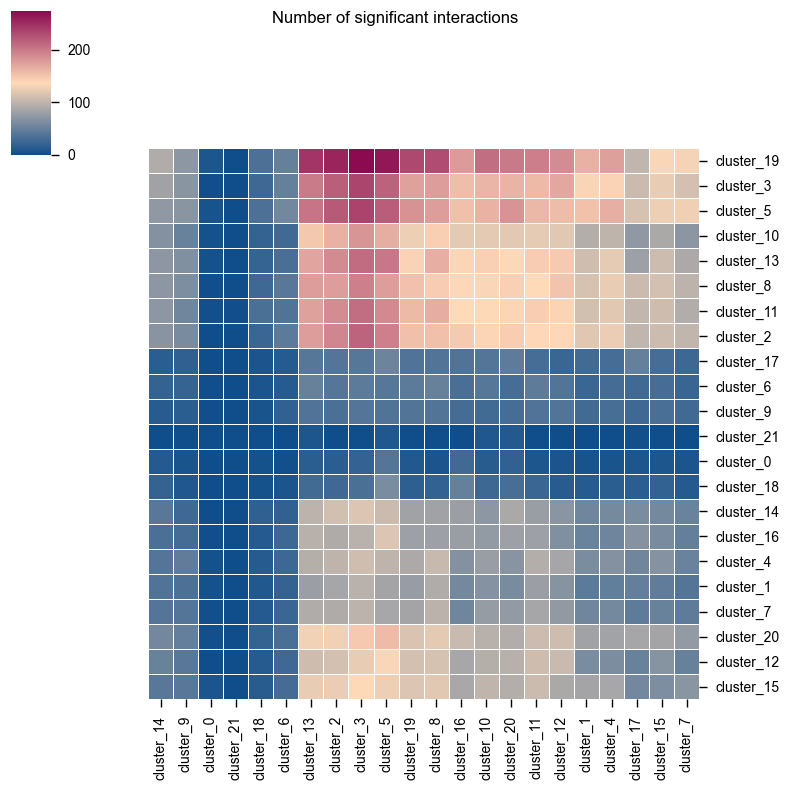

In [15]:
kpy.plot_cpdb_heatmap(
    pvals = cpdb_results_dict['pvalues'],
    figsize = (8,8),
    title = "Number of significant interactions",
    symmetrical = False,
    return_tables=False,
)

##### Collect ligands from CellPhoneDB

In [16]:
importlib.reload(cpw)
cpdb_network = cpw.build_cellphonedb_network(pvalues=cpdb_results_dict['pvalues'],
                                             means=cpdb_results_dict['means'],
                                             interaction_scores=cpdb_results_dict['interaction_scores'],
                                             mean_cutoff=0.05)

In [17]:
# Find how many ligands pointing to the focused cluster
cpdb_ligands = set()
for edge in cpdb_network.edges():
    src = edge[0]
    target = edge[1]
    if cpdb_network.nodes[target]['cluster'] == focused_cluster:
        src_gene = src.split(':')[1]
        cpdb_ligands.add(src_gene)
    # break
print('{}: {}'.format(len(cpdb_ligands), cpdb_ligands))

144: {'JAG1', 'BMP5', 'Inhibin_ligand_A', 'COL13A1', 'Pregnenolone_byCYP11A1', 'NRXN1', 'PTPRS', 'COL4A2', 'TNC', 'FLRT1', 'BTC', 'TENM4', 'LAMC1', 'BMP2', 'IGF1', 'CXCL10', 'EFNA3', 'PTPRF', 'TGFB1', 'TENM3', 'Desmosterol_byDHCR7', 'PLAU', 'EFNA4', 'IL1RAP', 'CXCL12', 'FGF1', 'CADM3', 'EFNA5', 'EFNB1', 'CD320', 'TENM4_FLRT1_complex', 'COL15A1', 'EFNB2', 'WNT7B', 'VTN', 'COL5A1', 'TGFA', 'BMP4', 'LTB', 'COL2A1', 'DLL1', 'FGF10', 'FGF9', 'DLK1', 'COL1A2', 'GAS6', 'TGFB2', 'GJA1', 'BDNF', 'TNFSF12', 'COL5A2', 'NGF', 'JAG2', 'COL4A5', 'COL9A3', 'COL27A1', 'COL16A1', 'COL6A3', 'CXCL2', 'AREG', 'INHA', '22Hydroxycholesterol_byCYP11A1', 'COL14A1', 'HGF', 'COL28A1', 'BMP6', 'THBS1', 'HBEGF', 'CSPG4', 'COL3A1', 'HFE', 'CNTN1', 'GJC1', 'NRXN2', 'CDH1', 'WNT5B', 'GDF10', 'FGFR4', 'DKK2', 'NECTIN2', 'VEGFA', 'SEMA4C', 'TGM2', 'COL4A6', 'FN1', 'APP', 'FLRT2', 'APOA1', 'RSPO1', 'COL11A1', 'FLRT3', 'PGF', 'EFNA2', 'CADM1', 'DSC2', 'SIRPA', 'GDF11', 'LAMA3', 'SEMA3F', 'TF', 'TNF', 'SOSTDC1', 'LRPAP1'

In [18]:
# Try to see what we have now
ligands_overlapped = [ligand for ligand in selected_ligands_from_da if ligand.upper() in cpdb_ligands]
for i, l in enumerate(ligands_overlapped):
    print('{}: {}'.format(i, l))

0: Nectin2
1: Tgfa
2: Dsc2
3: Lrpap1
4: Fn1
5: Lamc1
6: Dll1
7: Thbs1
8: Col27a1
9: Sema4g
10: Cadm1
11: Apoa1
12: Dll3
13: Cdh1
14: Efna1
15: Fgf9
16: Areg
17: Flrt3
18: Efnb1
19: Efnb2
20: Ghrl
21: Sirpa
22: Dlk1
23: Vegfa


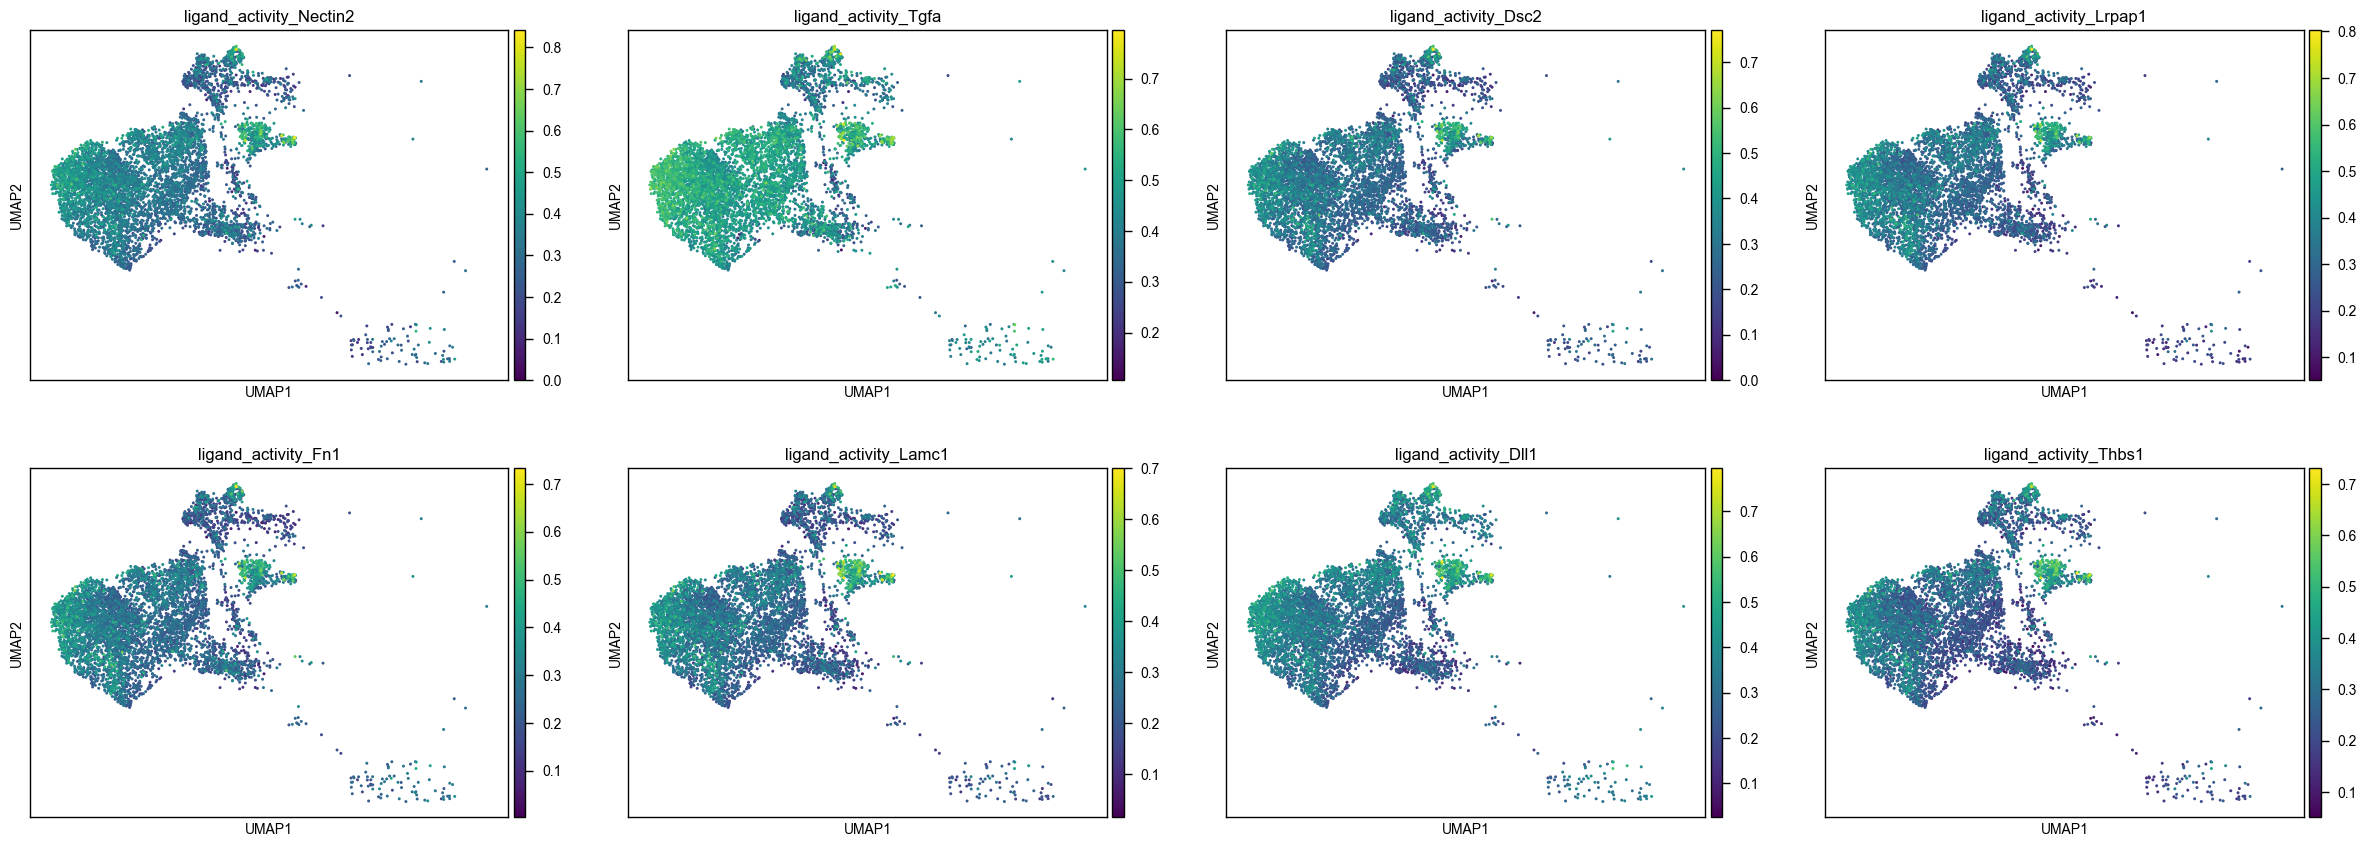

In [19]:
pathway_analyzer.color_pathway_umap(pathways=ligands_overlapped[:8], color_cluster=False, obs_name_prefix='ligand_activity_')
# pathway_analyzer.adata = adata
# pathway_analyzer.color_pathway_umap(pathways=ligands_overlapped[:8], color_cluster=False, obs_name_prefix='ligand_activity_')

**Note**: The overlapped ligands between CellPhoneDB and differential activity analysis, supported by NicheNet, will be used for the network construction. These ligands are not referred as ligands_selected.

In [20]:
ligands_selected = ligands_overlapped
print('Total selected ligands: {}'.format(len(ligands_selected)))
print(', '.join(ligands_selected))

Total selected ligands: 24
Nectin2, Tgfa, Dsc2, Lrpap1, Fn1, Lamc1, Dll1, Thbs1, Col27a1, Sema4g, Cadm1, Apoa1, Dll3, Cdh1, Efna1, Fgf9, Areg, Flrt3, Efnb1, Efnb2, Ghrl, Sirpa, Dlk1, Vegfa


##### Selected pathways by performing differential activity analysis

In [21]:
# Perform differential activity analysis
pathway_analyzer.adata = adata_epi
pathway_analyzer.adata_key = pa.AUCELL_KEY

pathway_activity_diff_df = pathway_analyzer.perform_diff_activity_analysis(group='1', 
                                                                           ref_group='0', 
                                                                           obs_key='focused_cluster', 
                                                                           need_diff=True)
pathway_activity_diff_df.head()

feature       stat  p-value  median_diff  \
0                         Metabolism of RNA  8102131.0      0.0     0.084782   
1         Eukaryotic Translation Initiation  8133808.5      0.0     0.050017   
2         Extracellular matrix organization  1656612.0      0.0    -0.021650   
3  Translation initiation complex formation  8012617.0      0.0     0.059089   
4  Formation of a pool of free 40S subunits  7926368.5      0.0     0.042369   

   mean_diff  fdr  
0   0.112194  0.0  
1   0.091837  0.0  
2  -0.030538  0.0  
3   0.097200  0.0  
4   0.085483  0.0

(<Axes: ylabel='median_diff'>, <Axes: ylabel='stat'>)

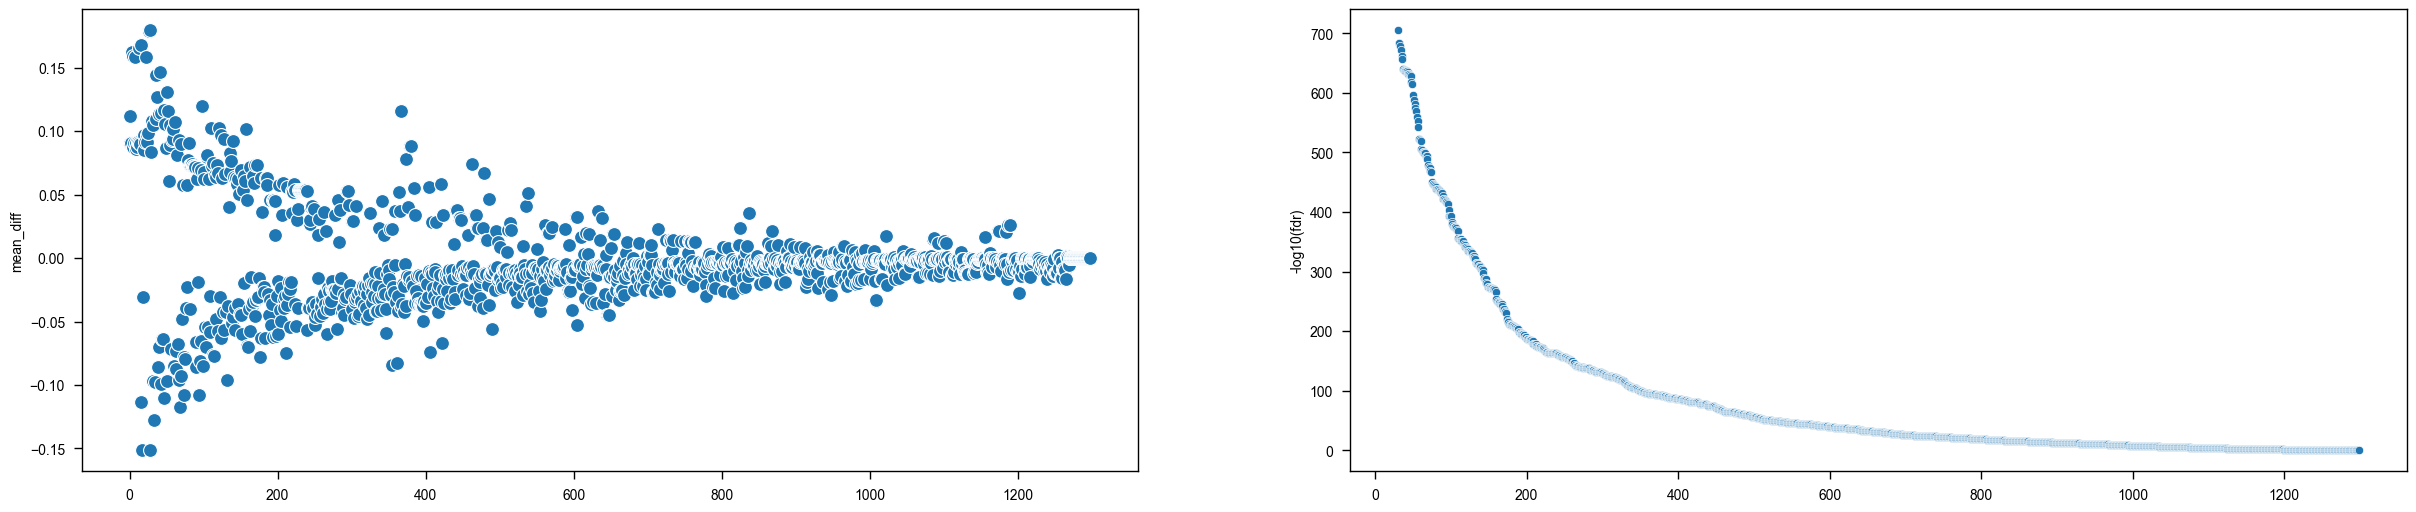

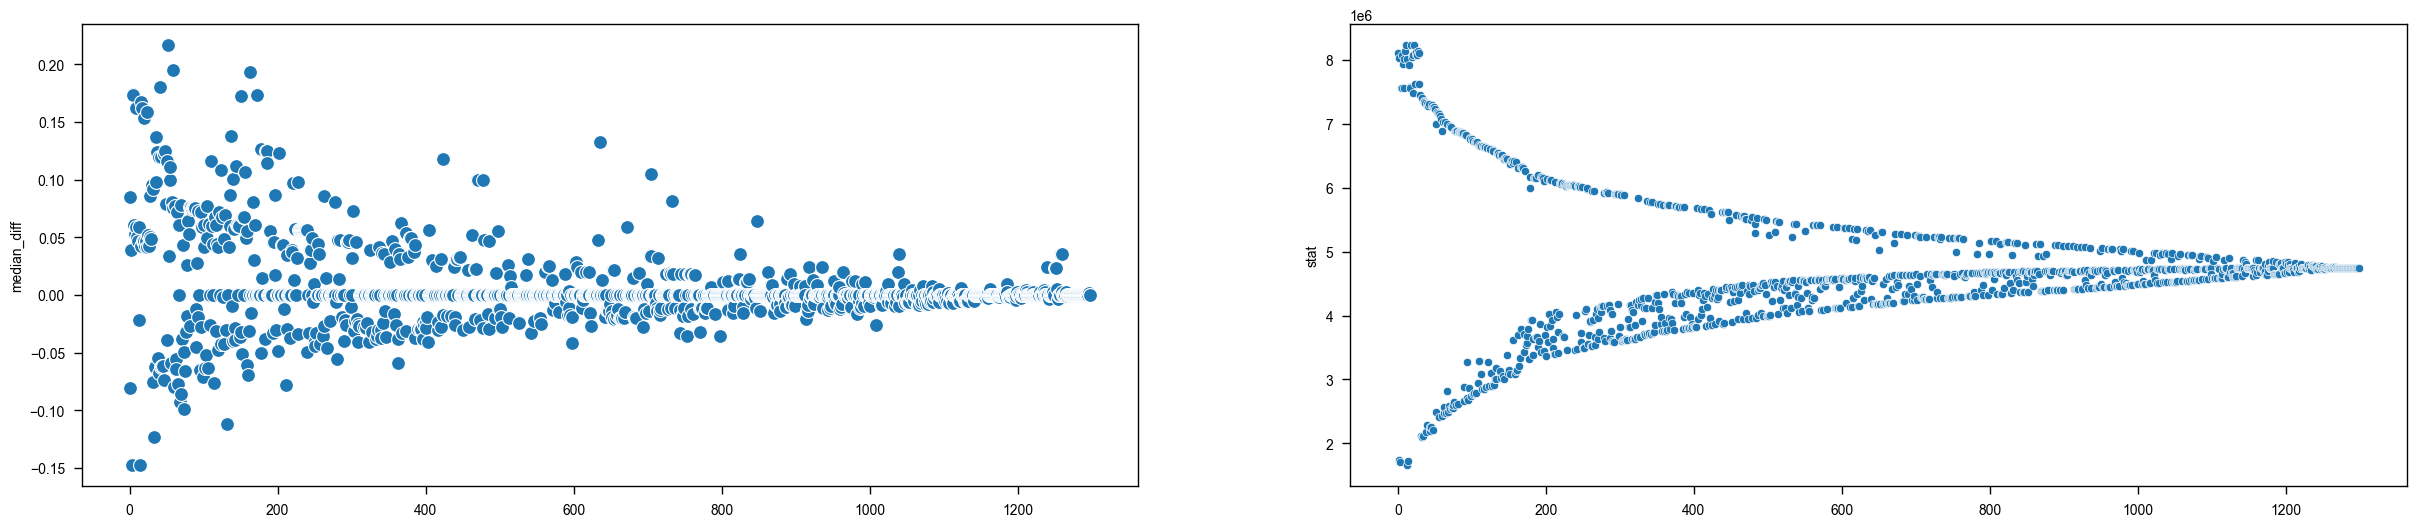

In [22]:
# Plot the results
rnc.plot_diff_activity(pathway_activity_diff_df, 
                       y1='mean_diff',
                       sort_by_fdr=True)
# Plot the results
rnc.plot_diff_activity(pathway_activity_diff_df, 
                       y1='median_diff',
                       y2='stat',
                       sort_by_fdr=True)

**Note**: Based on the above, it is quite to choose pathways. Therefore, we will use a combined set of criteria to choose pathways.

In [23]:
pathway_diff_cutoff = 0.025
pathway_fdr_cutoff = 0.001
which_pathways = (np.abs(pathway_activity_diff_df['mean_diff']) > pathway_diff_cutoff) & \
                 (np.abs(pathway_activity_diff_df['median_diff']) > pathway_diff_cutoff) & \
                 (pathway_activity_diff_df['fdr'] < pathway_fdr_cutoff)
print('Selected pathways: {}'.format(sum(which_pathways)))
pathway_activity_diff_df_selected = pathway_activity_diff_df.loc[which_pathways]
pathway_activity_diff_df_selected

Selected pathways: 284


feature       stat  \
0                                     Metabolism of RNA  8102131.0   
1                                  Membrane Trafficking  1736892.5   
2     SRP-dependent cotranslational protein targetin...  8023545.5   
3                    Metabolism of fat-soluble vitamins  1715819.5   
4      SLBP independent Processing of Histone Pre-mRNAs  7567669.5   
...                                                 ...        ...   
603                                          Aggrephagy  5370775.0   
623                                Metabolism of lipids  4147114.0   
633   Activation of the AP-1 family of transcription...  5339409.0   
1008  Synthesis of 12-eicosatetraenoic acid derivatives  4499626.0   
1009  Synthesis of 15-eicosatetraenoic acid derivatives  4500434.5   

           p-value  median_diff  mean_diff           fdr  -log10(fdr)  
0     0.000000e+00     0.084782   0.112194  0.000000e+00          inf  
1     0.000000e+00    -0.080229  -0.113334  0.000000e+00          inf  
2     0.000000e+00     0.038810   0.083557  0.000000e+00          inf  
3     0.000000e+00    -0.147605  -0.151470  0.000000e+00          inf  
4     0.000000e+00     0.174213   0.179545  0.000000e+00          inf  
...            ...          ...        ...           ...          ...  
603   5.110683e-18     0.028743   0.032483  1.099135e-17    39.049423  
623   4.871230e-17    -0.026805  -0.036498  1.014059e-16    36.827401  
633   1.649876e-16     0.047431   0.037022  3.380424e-16    35.623360  
1008  4.555303e-04    -0.025992  -0.033494  5.864558e-04     7.441413  
1009  4.752413e-04    -0.025572  -0.032917  6.112261e-04     7.400044  

[284 rows x 7 columns]

##### Plot pathways in the Reactome hierarchy for visualization

In [24]:
pathway_analyzer.scatter_plot_pathways(pathway_activity_diff_df, 
                                       feature_col='mean_diff',
                                       show=True) # Make sure show = True so that the plot can be displayed!
pathway_analyzer.scatter_plot_pathways(pathway_activity_diff_df, 
                                       show=True)
# pathway_analyzer.scatter_plot_pathways(pathway_activity_diff_df_selected, 
#                                        feature_col='mean_diff',
#                                        show=True) # Make sure show = True so that the plot can be displayed!
pathway_analyzer.scatter_plot_pathways(pathway_activity_diff_df_selected, 
                                       title='Selected Pathways',
                                       show=False)

##### Selected pathways

In [25]:
pathways_selected = pathway_activity_diff_df_selected['feature'].to_list()
print('Total pathways selected: {}'.format(len(pathways_selected)))
# print('; '.join(pathways_selected))

Total pathways selected: 284


##### Selected TFs via differential activity analysis

In [26]:
# Perform differential activity analysis for TFs
pathway_analyzer.adata_key = pa.TF_AUCELL_KEY
pathway_analyzer.adata = adata_epi

tf_diff_df = pathway_analyzer.perform_diff_activity_analysis(group='1',
                                                             ref_group='0',
                                                             obs_key='focused_cluster',
                                                             need_diff=True)
tf_diff_df.head()

feature       stat        p-value  median_diff  mean_diff            fdr
0     Myc  8153884.5   0.000000e+00     0.093985   0.114699   0.000000e+00
1    E2f4  7605253.0   0.000000e+00     0.072439   0.077329   0.000000e+00
2   Tfdp1  7159630.0  5.284205e-247     0.018082   0.030531  1.197753e-245
3    Sox2  2721339.0  1.580765e-237     0.000000  -0.029373  2.687301e-236
4   Foxa2  2545511.5  1.333021e-226    -0.227513  -0.146307  1.812908e-225

(<Axes: ylabel='median_diff'>, <Axes: ylabel='stat'>)

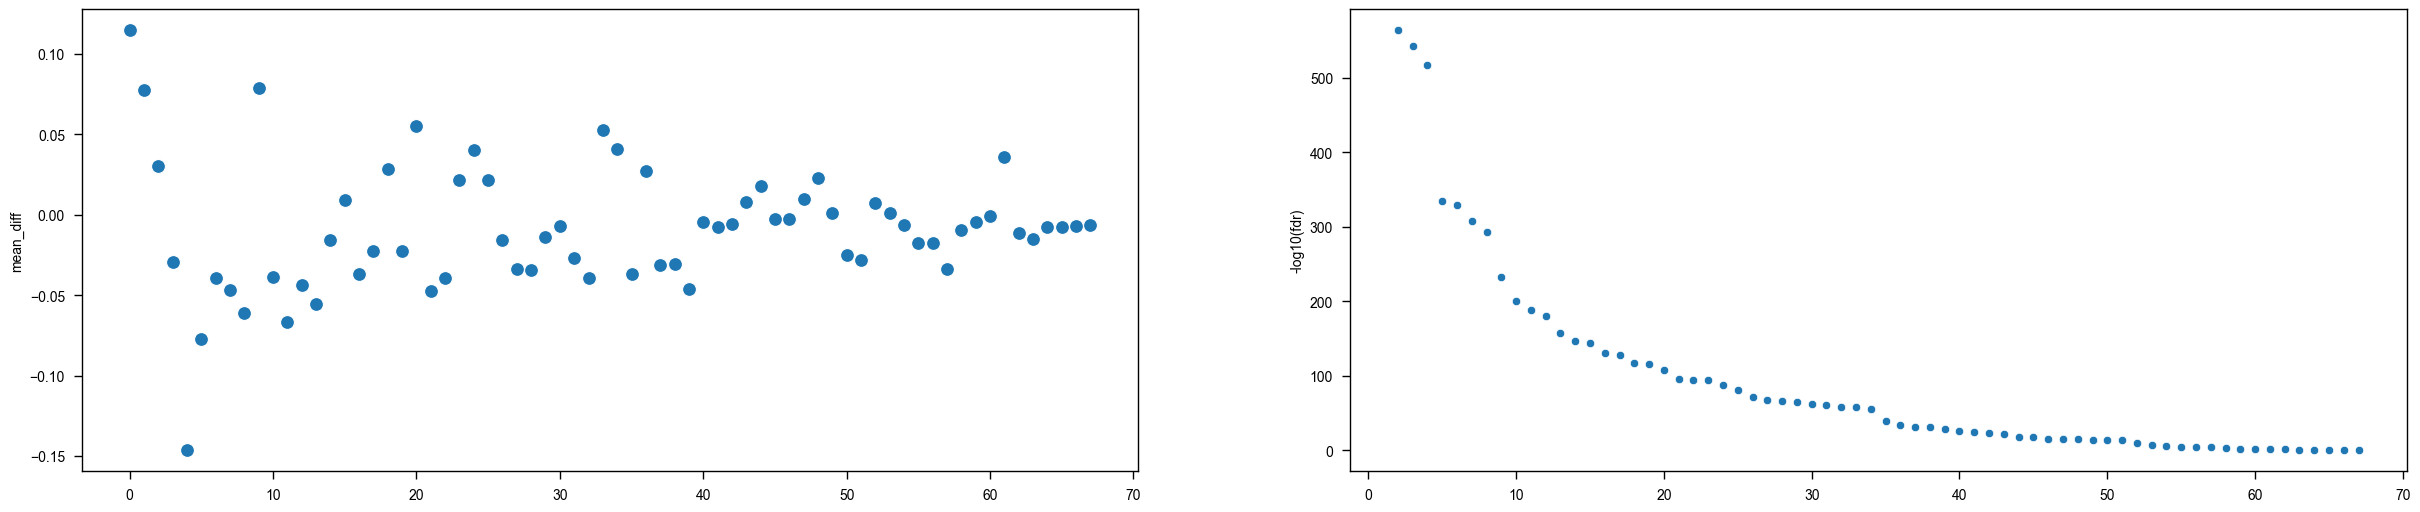

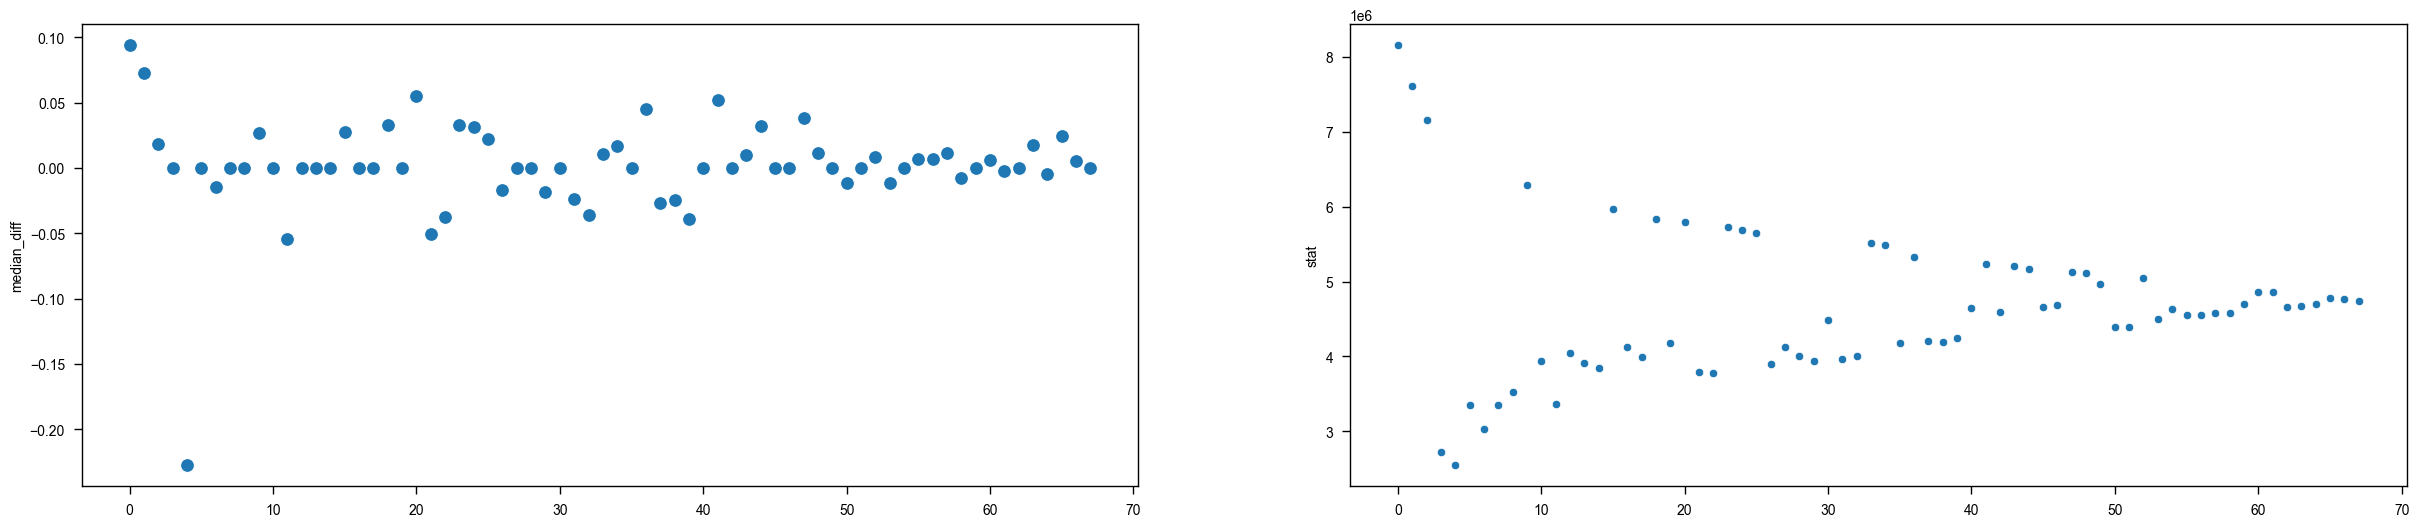

In [27]:
# Plot the results
rnc.plot_diff_activity(tf_diff_df, 
                       y1='mean_diff',
                       sort_by_fdr=True)
# Plot the results
rnc.plot_diff_activity(tf_diff_df, 
                       y1='median_diff',
                       y2='stat',
                       sort_by_fdr=True)

##### Selected TFs

In [28]:
tf_diff_cutoff = 0.025
tf_diff_fdr_cutoff = 0.001

which_tfs = (np.abs(tf_diff_df['mean_diff']) > tf_diff_cutoff) & \
    (np.abs(tf_diff_df['median_diff']) > tf_diff_cutoff) & \
    (tf_diff_df['fdr'] < tf_diff_fdr_cutoff)
print('Selected TFs: {}'.format(sum(which_tfs)))
tf_diff_df_selected = tf_diff_df.loc[which_tfs]
print(tf_diff_df_selected.head())

selected_tfs = tf_diff_df_selected['feature'].to_list()
print('Total tfs selected: {}'.format(len(selected_tfs)))
print(', '.join(selected_tfs))

Selected TFs: 14
   feature       stat        p-value  median_diff  mean_diff            fdr  \
0      Myc  8153884.5   0.000000e+00     0.093985   0.114699   0.000000e+00   
1     E2f4  7605253.0   0.000000e+00     0.072439   0.077329   0.000000e+00   
4    Foxa2  2545511.5  1.333021e-226    -0.227513  -0.146307  1.812908e-225   
9     Atf1  6293294.5  1.406276e-102     0.026721   0.078895  9.562674e-102   
11      Ar  3362775.5   4.223018e-83    -0.054320  -0.066331   2.393043e-82   

    -log10(fdr)  
0           inf  
1           inf  
4    517.486714  
9    232.605812  
11   187.939412  
Total tfs selected: 14
Myc, E2f4, Foxa2, Atf1, Ar, Foxm1, Esr2, Wt1, Ctcf, Usf1, Rara, Srf, Srebf1, Fosl2


#### Perform correlation analyses between pathways and TFs, ligands

##### Perform correlation analysis between pathways and TFs using GLM

**Note**: This analysis is performed for all epithethial cells, not just the focused cluster to increase the sensititivy.

In [82]:
importlib.reload(rnc)
# From now on using spearman corrleation instead of GLM due to the potentially strong colinear relationships among TF acivities
pathway_tf_cor = rnc.analyze_tf_pathway_correlations_via_spearman(adata=adata_epi,
                                                                  pathways=pathways_selected,
                                                                  tfs=selected_tfs)
pathway_tf_cor.head()

100%|██████████| 284/284 [00:06<00:00, 45.77it/s]


pathway     tf       cor   cor_p_value           fdr
0  Metabolism of RNA    Myc  0.814391  0.000000e+00  0.000000e+00
1  Metabolism of RNA   E2f4  0.629553  0.000000e+00  0.000000e+00
2  Metabolism of RNA  Foxa2 -0.554220  0.000000e+00  0.000000e+00
3  Metabolism of RNA   Atf1  0.174620  9.308512e-46  2.270592e-45
4  Metabolism of RNA     Ar -0.221823  2.037918e-73  6.919523e-73

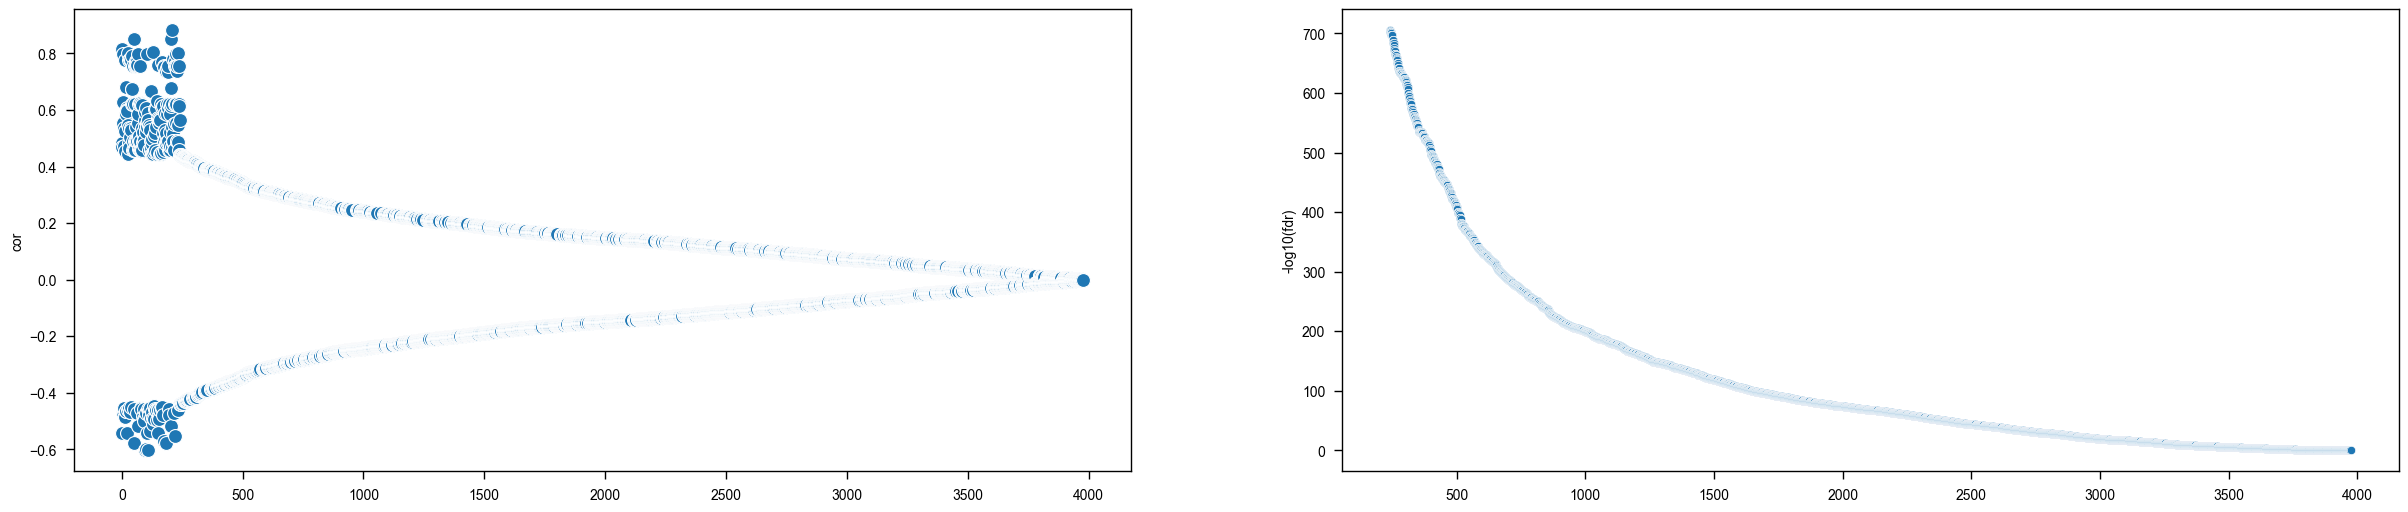

In [83]:
# Look at the results
cor_plot, pvalue_plot = rnc.plot_diff_activity(pathway_tf_cor, y1='cor', sort_by_fdr=True)

Based on the above plot, we will choose the following cutoff values:

abs(cor) >= 0.25

#### Build the network between pathways and tfs first

In [84]:
importlib.reload(rnc)
importlib.reload(pa)

tf_pathway_cor_cutoff = 0.20
tf_cor_cutoff = 0.25  # For building TF/TF relationships
fdr_cutoff = 1.0e-5
geneset_overlap_pvalue_cutoff = 0.01
pathway_hierarchy_file = '../resources/MouseReactomePathways_Hierarchy_Rel_79_122921.xml'
pathway_gmt_file = '../resources/MouseReactomePathways_Rel_79_122921.gmt'
tf_file = '../resources/dorothea_mm.tsv'

network = rnc.build_network_for_tfs_pathways(pathway_tf_cor,
                                             cor_cutoff=tf_pathway_cor_cutoff,
                                             fdr_cutoff=fdr_cutoff)

s_leaf_network, overlap_p_values = rnc.simplify_network_for_tfs_pathways(network,
                                                                         pathway_gmt_file=pathway_gmt_file,
                                                                         pathway_hierarchy_file=pathway_hierarchy_file,
                                                                         tf_file=tf_file,
                                                                         need_parent_pathway=True,
                                                                         use_direct_interaction=True,
                                                                         p_value_for_direction_interaction=geneset_overlap_pvalue_cutoff,
                                                                         for_pathway_only=False,
                                                                         add_tf_links=True,
                                                                         check_with_tf_cor=True,
                                                                         adata=adata_epi,
                                                                         tf_cor_cutoff=tf_cor_cutoff,
                                                                         add_pathway_to_tf_links=True,
                                                                         delete_pathway_only_component=True,
                                                                         delete_leaf_pathway=False)

network_file_name = working_dir + 'regulatory_network_cluster_{}_{}_04122023'.format(
    focused_cluster, tf_pathway_cor_cutoff) + '.graphml'
rnc.write_network_to_graphml(s_leaf_network, network_file_name)

#### Repeat the network construction using focused cells only

In [81]:
pathway_tf_cor.head()

pathway     tf       cor    cor_p_value            fdr
0  Metabolism of RNA    Myc  0.529880  6.972399e-160  2.918132e-158
1  Metabolism of RNA   E2f4  0.377988   7.939527e-76   1.510410e-74
2  Metabolism of RNA  Foxa2 -0.563184  9.341006e-185  6.189973e-183
3  Metabolism of RNA   Atf1  0.003601   8.658072e-01   8.806471e-01
4  Metabolism of RNA     Ar -0.338332   3.505203e-60   5.086382e-59

In [80]:
adata_epi_cluster = adata_epi[adata_epi.obs['leiden'] == focused_cluster]
pathway_tf_cor = rnc.analyze_tf_pathway_correlations_via_spearman(adata=adata_epi_cluster,
                                                                  pathways=pathways_selected,
                                                                  tfs=selected_tfs)
network_cluster = rnc.build_network_for_tfs_pathways(pathway_tf_cor,
                                             cor_cutoff=tf_pathway_cor_cutoff,
                                             fdr_cutoff=fdr_cutoff)
s_leaf_network, overlap_p_values = rnc.simplify_network_for_tfs_pathways(network_cluster,
                                                                         pathway_gmt_file=pathway_gmt_file,
                                                                         pathway_hierarchy_file=pathway_hierarchy_file,
                                                                         tf_file=tf_file,
                                                                         need_parent_pathway=True,
                                                                         use_direct_interaction=True,
                                                                         p_value_for_direction_interaction=geneset_overlap_pvalue_cutoff,
                                                                         for_pathway_only=False,
                                                                         add_tf_links=True,
                                                                         check_with_tf_cor=True,
                                                                         adata=adata_epi,
                                                                         tf_cor_cutoff=tf_cor_cutoff,
                                                                         add_pathway_to_tf_links=True,
                                                                         delete_pathway_only_component=True,
                                                                         delete_leaf_pathway=False)

network_file_name = working_dir + 'regulatory_network_cluster_{}_{}_cluster_cells_04122023'.format(focused_cluster, tf_pathway_cor_cutoff) + '.graphml'
rnc.write_network_to_graphml(s_leaf_network, network_file_name)


100%|██████████| 284/284 [00:06<00:00, 43.22it/s]


**Note**: Based on the visualization of the two graphml files in Cytoscape, apparently the network using all cells provides more information. Therefore, we will use that.

#### Add ligands to the network

In [67]:
ligand2targets = nichenet.get_ligand_2_targets()
print('Total ligands: {}'.format(len(ligand2targets)))

Total ligands: 1287


In [85]:
importlib.reload(rnc)

pathway_gmt_file = '../resources/MouseReactomePathways_Rel_79_122921.gmt'
graphml_file = working_dir + 'regulatory_network_cluster_{}_{}_with_ligands_04122023'.format(focused_cluster, tf_pathway_cor_cutoff) + '.graphml'
ligand_pathway_cor_cutoff = 0.25
ligand_pathway_cor_pvalue_cutoff = 1.0E-5
overlap_fdr_cutoff = 1.0E-3

# Note: The network we'd like to use is s_leaf_network
# To try a different parameters, we need to re-generated s_leaf_network
s_leaf_network, overlap_p_values = rnc.simplify_network_for_tfs_pathways(network,
                                                                        pathway_gmt_file=pathway_gmt_file,
                                                                        pathway_hierarchy_file=pathway_hierarchy_file,
                                                                        tf_file=tf_file,
                                                                        need_parent_pathway=False,
                                                                        use_direct_interaction=True,
                                                                        p_value_for_direction_interaction=geneset_overlap_pvalue_cutoff,
                                                                        for_pathway_only=False,
                                                                        add_tf_links=True,
                                                                        check_with_tf_cor=True,
                                                                        adata=adata_epi,
                                                                        tf_cor_cutoff=tf_cor_cutoff,
                                                                        add_pathway_to_tf_links=True,
                                                                        delete_pathway_only_component=True,
                                                                        delete_leaf_pathway=False)

network_with_ligand, ligand_pathway_cor_df = rnc.add_ligands_to_network_via_pathways(ligands=ligands_selected,
                                                                         network=s_leaf_network,
                                                                         adata=adata_epi,
                                                                         pathway_gmt_file=pathway_gmt_file,
                                                                         ligand2targets=ligand2targets,
                                                                         overlap_fdr_cutoff=overlap_fdr_cutoff,
                                                                         cor_cutoff=ligand_pathway_cor_cutoff,
                                                                         cor_pvalue_cutoff=ligand_pathway_cor_pvalue_cutoff,
                                                                         use_tf_linked_pathways=True,
                                                                         graphml=graphml_file)
display(HTML(ligand_pathway_cor_df.to_html()))

100%|██████████| 44/44 [00:02<00:00, 19.58it/s]


##### Check some ligand's activities

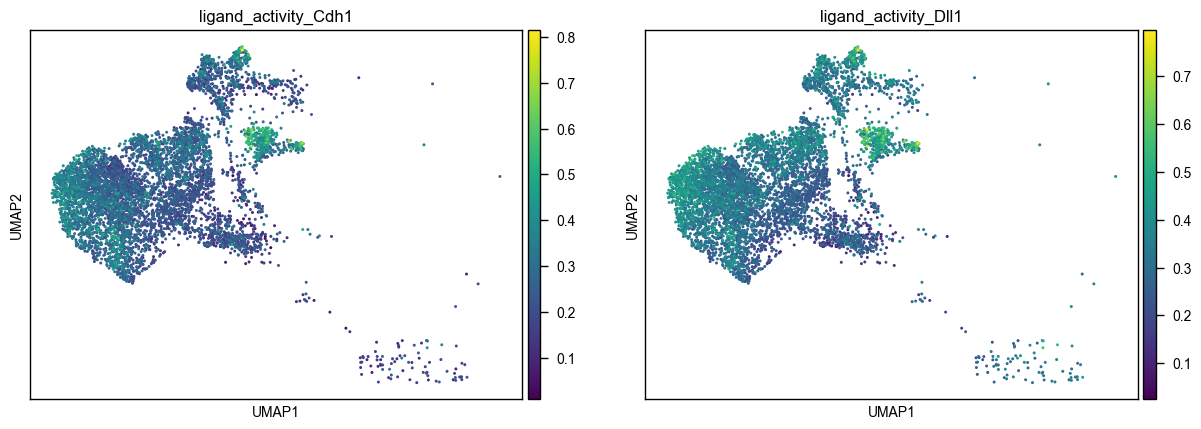

In [69]:
ligands_to_be_checked = ['Cdh1', 'Dll1']
pathway_analyzer.adata_key = pa.LIGAND_AUCELL_KEY
pathway_analyzer.color_pathway_umap(ligands_to_be_checked,
                                    color_cluster=False,
                                    obs_name_prefix='ligand_activity_')

In [87]:
cor_df[cor_df['pathway'] == 'Regulation of RUNX1 Expression and Activity'].sort_values(by='ligand')

ligand                                      pathway       cor  \
28    Apoa1  Regulation of RUNX1 Expression and Activity  0.193819   
29     Cdh1  Regulation of RUNX1 Expression and Activity  0.146397   
26  Col27a1  Regulation of RUNX1 Expression and Activity  0.192230   
24     Dll1  Regulation of RUNX1 Expression and Activity  0.242258   
20     Dsc2  Regulation of RUNX1 Expression and Activity  0.241223   
30    Efna1  Regulation of RUNX1 Expression and Activity  0.183326   
33    Efnb1  Regulation of RUNX1 Expression and Activity  0.164372   
34    Efnb2  Regulation of RUNX1 Expression and Activity  0.167108   
31     Fgf9  Regulation of RUNX1 Expression and Activity  0.144187   
32    Flrt3  Regulation of RUNX1 Expression and Activity  0.180817   
22      Fn1  Regulation of RUNX1 Expression and Activity  0.223060   
35     Ghrl  Regulation of RUNX1 Expression and Activity  0.134038   
23    Lamc1  Regulation of RUNX1 Expression and Activity  0.224234   
21   Lrpap1  Regulation of RUNX1 Expression and Activity  0.242473   
19  Nectin2  Regulation of RUNX1 Expression and Activity  0.308525   
27   Sema4g  Regulation of RUNX1 Expression and Activity  0.205760   
36    Sirpa  Regulation of RUNX1 Expression and Activity  0.145924   
25    Thbs1  Regulation of RUNX1 Expression and Activity  0.205850   

      cor_p_value  overlap_p_value  
28   3.721149e-56     4.705952e-07  
29   1.568910e-32     2.237679e-05  
26   2.983352e-55     2.287065e-05  
24   1.253108e-87     4.613977e-04  
20   7.105455e-87     8.214852e-04  
30   2.487543e-50     2.440073e-05  
33   1.126328e-40     2.237679e-05  
34   5.322736e-42     2.237679e-05  
31   1.347355e-31     2.600534e-05  
32   5.468569e-49     1.704672e-05  
22   3.075651e-74     2.337253e-05  
35   1.705153e-27     2.492720e-05  
23   5.059646e-75     2.492720e-05  
21   8.731046e-88     3.892018e-07  
19  1.205044e-143     6.193043e-04  
27   3.296494e-63     1.957759e-05  
36   2.492650e-32     4.225834e-07  
25   2.902790e-63     3.579538e-07

<Axes: xlabel='Dll1', ylabel='Cdh1'>

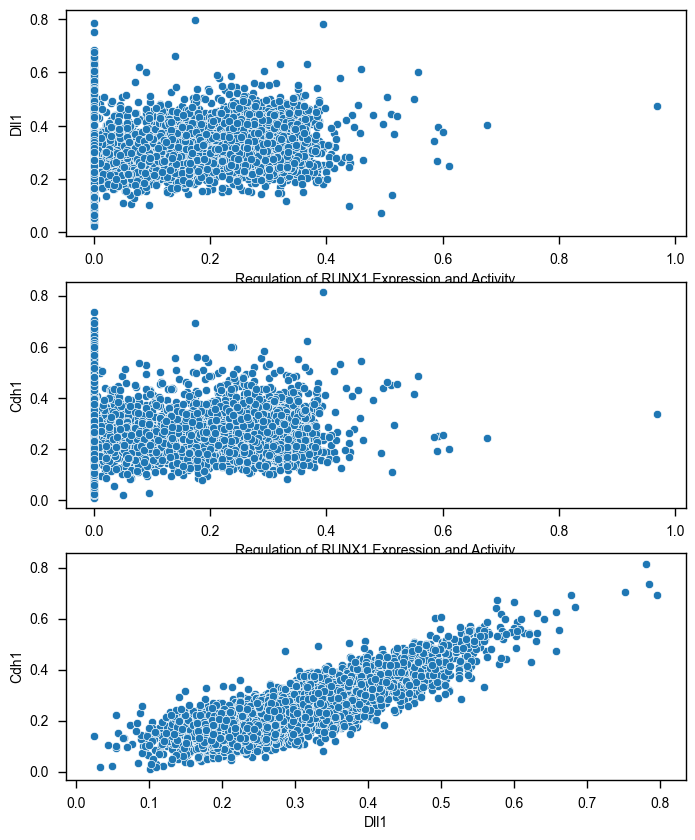

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(8, 10))

sns.scatterplot(x=adata_epi.obsm[pa.AUCELL_KEY]['Regulation of RUNX1 Expression and Activity'],
                y=adata_epi.obsm[pa.LIGAND_AUCELL_KEY]['Dll1'],
                ax=axes[0])
sns.scatterplot(x=adata_epi.obsm[pa.AUCELL_KEY]['Regulation of RUNX1 Expression and Activity'],
                y=adata_epi.obsm[pa.LIGAND_AUCELL_KEY]['Cdh1'],
                ax=axes[1])
sns.scatterplot(x=adata_epi.obsm[pa.LIGAND_AUCELL_KEY]['Dll1'],
                y=adata_epi.obsm[pa.LIGAND_AUCELL_KEY]['Cdh1'],
                ax=axes[2])